### Imports

In [1]:
import os
import time
import math
import random
import pickle
import shutil
import warnings

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from models import *
from autoencoder import *
from utils import *
from data import *

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

### Configuration Setup

Defines experiment parameters, including latent dimension size, datasets with associated window sizes, embedding usage flags, and distance metrics. The compute device (CPU/GPU) is selected automatically.

In [2]:
# Configuration Parameters
latent_dim = 8

# Dataset configurations: (Name, Class, Sequence Length, Window Size)
ts_configs = [
    ("PowerDemand",  PowerDemand,  None,  8),
    ("Saugeen",      Saugeen,      10000, 10),
    ("Temperatures", Temperatures, None,  10),
]

# Flags to toggle use of autoencoder embeddings
autoencoder_embedding_flags = [False, True]

# Distance metrics to evaluate
metrics_list = ["euclidean", "manhattan", "cosine"]

# Set device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Autoencoder Training and Evaluation

For each dataset, a convolutional autoencoder is trained on windowed time-series data using MSE loss. The model is trained for 30 epochs and saved for later use.

Post-training, reconstruction quality is assessed both qualitatively (via plots) and quantitatively (via MSE) on train, validation, and test splits. These latent representations will be used for model selection in later stages.


Training AE on PowerDemand (window_size=8)
  Epoch 1/30 — loss: 0.712215
  Epoch 2/30 — loss: 0.298650
  Epoch 3/30 — loss: 0.219838
  Epoch 4/30 — loss: 0.190311
  Epoch 5/30 — loss: 0.174218
  Epoch 6/30 — loss: 0.165990
  Epoch 7/30 — loss: 0.162809
  Epoch 8/30 — loss: 0.156619
  Epoch 9/30 — loss: 0.151150
  Epoch 10/30 — loss: 0.146713
  Epoch 11/30 — loss: 0.144023
  Epoch 12/30 — loss: 0.142147
  Epoch 13/30 — loss: 0.140033
  Epoch 14/30 — loss: 0.137832
  Epoch 15/30 — loss: 0.136699
  Epoch 16/30 — loss: 0.134724
  Epoch 17/30 — loss: 0.132824
  Epoch 18/30 — loss: 0.130363
  Epoch 19/30 — loss: 0.129726
  Epoch 20/30 — loss: 0.127221
  Epoch 21/30 — loss: 0.124698
  Epoch 22/30 — loss: 0.127120
  Epoch 23/30 — loss: 0.124799
  Epoch 24/30 — loss: 0.123052
  Epoch 25/30 — loss: 0.122053
  Epoch 26/30 — loss: 0.121505
  Epoch 27/30 — loss: 0.121439
  Epoch 28/30 — loss: 0.119918
  Epoch 29/30 — loss: 0.117978
  Epoch 30/30 — loss: 0.119188
Saved AE: autoencoders\ae_PowerDema

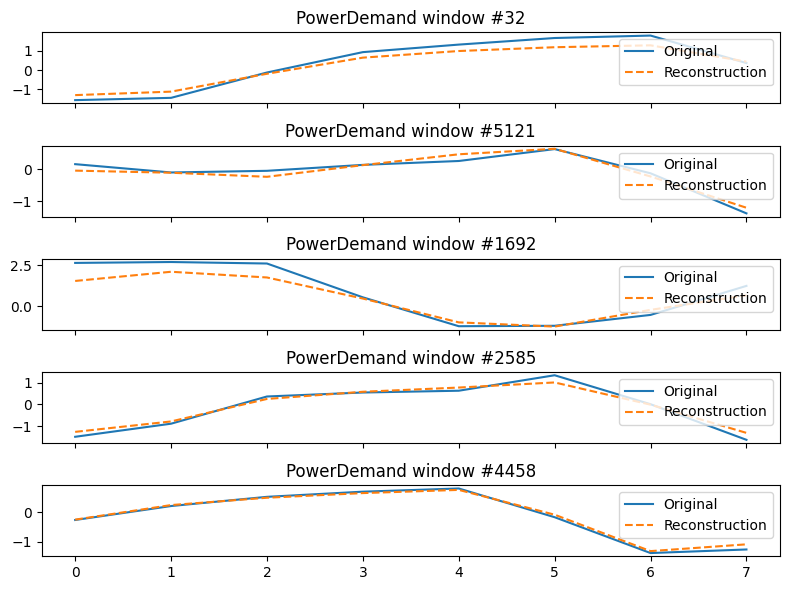


Training AE on Saugeen (window_size=10)
  Epoch 1/30 — loss: 0.542519
  Epoch 2/30 — loss: 0.285450
  Epoch 3/30 — loss: 0.221677
  Epoch 4/30 — loss: 0.216366
  Epoch 5/30 — loss: 0.174094
  Epoch 6/30 — loss: 0.164996
  Epoch 7/30 — loss: 0.155275
  Epoch 8/30 — loss: 0.167649
  Epoch 9/30 — loss: 0.151458
  Epoch 10/30 — loss: 0.130322
  Epoch 11/30 — loss: 0.138482
  Epoch 12/30 — loss: 0.133390
  Epoch 13/30 — loss: 0.129260
  Epoch 14/30 — loss: 0.127387
  Epoch 15/30 — loss: 0.135049
  Epoch 16/30 — loss: 0.142022
  Epoch 17/30 — loss: 0.143046
  Epoch 18/30 — loss: 0.126589
  Epoch 19/30 — loss: 0.119428
  Epoch 20/30 — loss: 0.139980
  Epoch 21/30 — loss: 0.119184
  Epoch 22/30 — loss: 0.118559
  Epoch 23/30 — loss: 0.139806
  Epoch 24/30 — loss: 0.123297
  Epoch 25/30 — loss: 0.129654
  Epoch 26/30 — loss: 0.113097
  Epoch 27/30 — loss: 0.135947
  Epoch 28/30 — loss: 0.111936
  Epoch 29/30 — loss: 0.113049
  Epoch 30/30 — loss: 0.110025
Saved AE: autoencoders\ae_Saugeen.pth


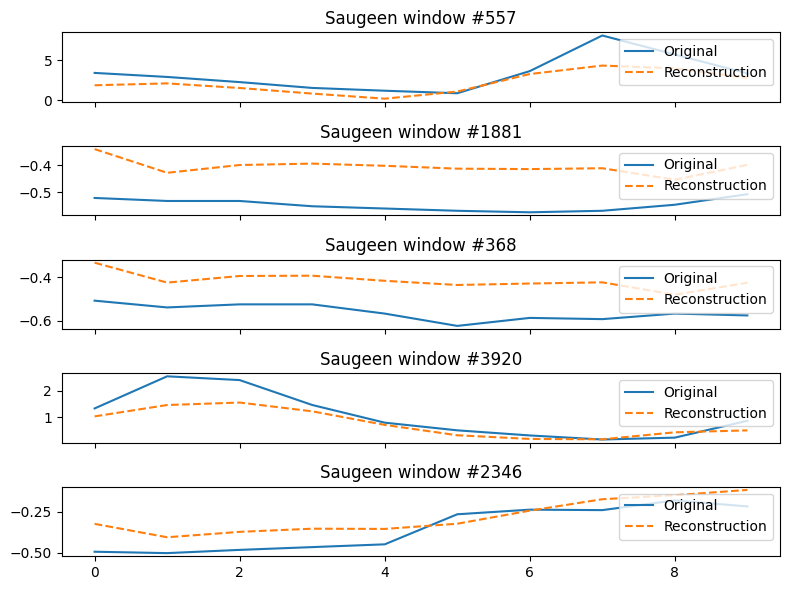


Training AE on Temperatures (window_size=10)
  Epoch 1/30 — loss: 0.963300
  Epoch 2/30 — loss: 0.503832
  Epoch 3/30 — loss: 0.418134
  Epoch 4/30 — loss: 0.366587
  Epoch 5/30 — loss: 0.324334
  Epoch 6/30 — loss: 0.293519
  Epoch 7/30 — loss: 0.275864
  Epoch 8/30 — loss: 0.254393
  Epoch 9/30 — loss: 0.240677
  Epoch 10/30 — loss: 0.234462
  Epoch 11/30 — loss: 0.227900
  Epoch 12/30 — loss: 0.213938
  Epoch 13/30 — loss: 0.210086
  Epoch 14/30 — loss: 0.217010
  Epoch 15/30 — loss: 0.209566
  Epoch 16/30 — loss: 0.200071
  Epoch 17/30 — loss: 0.201613
  Epoch 18/30 — loss: 0.200789
  Epoch 19/30 — loss: 0.198702
  Epoch 20/30 — loss: 0.191439
  Epoch 21/30 — loss: 0.195412
  Epoch 22/30 — loss: 0.206680
  Epoch 23/30 — loss: 0.202583
  Epoch 24/30 — loss: 0.181623
  Epoch 25/30 — loss: 0.189866
  Epoch 26/30 — loss: 0.175287
  Epoch 27/30 — loss: 0.179737
  Epoch 28/30 — loss: 0.185114
  Epoch 29/30 — loss: 0.172997
  Epoch 30/30 — loss: 0.177169
Saved AE: autoencoders\ae_Tempera

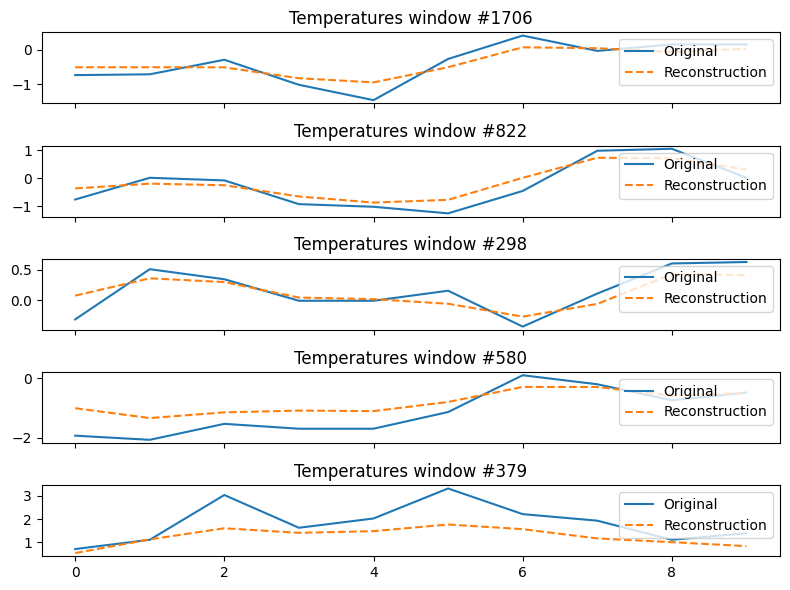

In [3]:
# Autoencoder Training Settings
epochs    = 30
lr        = 1e-3
dropout_p = 0.6

# Ensure a clean autoencoders/ directory
AE_DIR = "autoencoders"
if os.path.exists(AE_DIR):
    shutil.rmtree(AE_DIR)
os.makedirs(AE_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\nTraining AE on {ds_name} (window_size={window_size})")
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    
    
    # model + optimizer + loss
    ae        = ConvAutoencoder1D(window_size, latent_dim, dropout_p).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # wrap as DataLoader of shape (batch, 1, window_size)
    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float).unsqueeze(1)),
        batch_size=128, shuffle=True
    )
    
    # training loop
    for epoch in range(1, epochs + 1):
        losses = []
        ae.train()
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon   = ae(batch_x)
            loss    = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"  Epoch {epoch}/{epochs} — loss: {np.mean(losses):.6f}")
    
    # save per‐dataset autoencoder
    ckpt_path = os.path.join("autoencoders", f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)
    print(f"Saved AE: {ckpt_path}")

    # 6. Visualize reconstructions in eval mode
    ae.eval()
    sample_idxs = random.sample(range(len(X_train)), 5)
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    for ax, idx in zip(axes, sample_idxs):
        orig = X_train[idx]
        with torch.no_grad():
            inp = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, linestyle="--", label="Reconstruction")
        ax.set_title(f"{ds_name} window #{idx}")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

### Forecaster Training

For each dataset, a collection of classical and neural network-based forecasters is trained on the training split. Each trained model is saved as a serialized `.pkl` file for future evaluation and selection.

In [4]:
# Ensure a clean models/ directory
MODEL_DIR = "models"
if os.path.exists(MODEL_DIR):
    shutil.rmtree(MODEL_DIR)
os.makedirs(MODEL_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Dataset: {ds_name} (window_size={window_size})")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    forecasters = {
    "ARIMA": ARIMAForecaster(),
    "ExpSmoothing": ExpSmoothingForecaster(),
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(),
    "SVR": SVRForecaster(),
    "GradientBoosting": GradientBoostingForecaster(),
    "DT": DecisionTreeForecaster(),
    "MLP": MLPForecaster(),
    "LSTM": LSTMForecaster(window_size=window_size),
    "BiLSTM": BiLSTMForecaster(window_size=window_size),
    "CNNLSTM": CNNLSTMForecaster(window_size=window_size),
    }

    for name, model in forecasters.items():
        print(f"    → Training {name}…", end=" ")
        model.fit(X_train, y_train)

        # save the entire model object as a .pkl
        save_path = os.path.join("models", f"{ds_name}_{name}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"DONE")


→ Dataset: PowerDemand (window_size=8)
    → Training ARIMA… DONE
    → Training ExpSmoothing… DONE
    → Training LinearRegression… DONE
    → Training RandomForest… DONE
    → Training SVR… DONE
    → Training GradientBoosting… DONE
    → Training DT… DONE
    → Training MLP… DONE
    → Training LSTM… 1/30 0.71865 | 15/30 0.05782 | 30/30 0.05224 | DONE
    → Training BiLSTM… 1/30 0.70870 | 15/30 0.05493 | 30/30 0.05196 | DONE
    → Training CNNLSTM… 1/30 0.47929 | 15/30 0.04500 | 30/30 0.04166 | DONE

→ Dataset: Saugeen (window_size=10)
    → Training ARIMA… DONE
    → Training ExpSmoothing… DONE
    → Training LinearRegression… DONE
    → Training RandomForest… DONE
    → Training SVR… DONE
    → Training GradientBoosting… DONE
    → Training DT… DONE
    → Training MLP… DONE
    → Training LSTM… 1/30 0.64738 | 15/30 0.07585 | 30/30 0.07229 | DONE
    → Training BiLSTM… 1/30 0.67736 | 15/30 0.07771 | 30/30 0.07184 | DONE
    → Training CNNLSTM… 1/30 0.47764 | 15/30 0.07453 | 30/30 

### Model Loading

Pretrained autoencoders and forecasters are loaded from disk for each dataset. These models are stored in a dictionary for subsequent evaluation and model selection steps.

In [5]:
MODELS_DIR = "models"
AE_DIR = "autoencoders"

os.makedirs(AE_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

loaded = {}
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Loading models for {ds_name} (window_size={window_size})")
    
    # Load Autoencoder
    ae = ConvAutoencoder1D(window_size, latent_dim, dropout_p).eval().to(device)
    ae_ckpt = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=device))
    print(f"     AE loaded from {AE_DIR}{os.sep}")
    
    # Load Forecasters
    forecasters = {}
    for name in [
        "ARIMA",
        "ExpSmoothing",
        "LinearRegression",
        "RandomForest",
        "SVR",
        "GradientBoosting",
        "DT",
        "MLP",
        "LSTM",
        "BiLSTM",
        "CNNLSTM",
    ]:
        pkl_path = os.path.join(MODELS_DIR, f"{ds_name}_{name}.pkl")
        with open(pkl_path, "rb") as f:
            forecasters[name] = pickle.load(f)
    print(f"     Forecasters loaded from {MODELS_DIR}{os.sep}")
    
    # Store for later
    loaded[ds_name] = {
        "ae": ae,
        "forecasters": forecasters
    }


→ Loading models for PowerDemand (window_size=8)
     AE loaded from autoencoders\
     Forecasters loaded from models\

→ Loading models for Saugeen (window_size=10)
     AE loaded from autoencoders\
     Forecasters loaded from models\

→ Loading models for Temperatures (window_size=10)
     AE loaded from autoencoders\
     Forecasters loaded from models\


### Validation Phase: Region of Competence Construction

Each validation window is used to evaluate all forecasters. The model with the lowest prediction error receives the window as part of its Region of Competence (RoC), stored in both raw and latent representations.


In [ ]:
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Validation RoC for {ds_name} (window_size={window_size}) ===")
    
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear both RoCs
    for model in forecasters.values():
        model.rocs["raw"].clear()
        model.rocs["latent"].clear()

    # Iterate once over validation windows
    for idx, window in enumerate(X_val):
        # a) Pick winner based on raw input
        errors = {}
        for name, model in forecasters.items():
            y_pred = model.predict(window)
            errors[name] = mean_squared_error([y_val[idx]], [y_pred])
        winner = min(errors, key=errors.get)

        # b) Store both raw and latent versions
        raw_vec = window
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(raw_vec)
        forecasters[winner].rocs["latent"].append(latent_vec)

    # Report results
    print("RoC sizes")
    for name, model in forecasters.items():
        count = len(model.rocs["raw"])
        print(f"  {name:<18} {count:4d} entries")


=== Validation RoC for PowerDemand (window_size=8) ===
RoC sizes
  ARIMA               120 entries
  ExpSmoothing        192 entries
  LinearRegression    277 entries
  RandomForest        212 entries
  SVR                 355 entries
  GradientBoosting    236 entries
  DT                  265 entries
  MLP                 356 entries
  LSTM                280 entries
  BiLSTM              252 entries
  CNNLSTM             369 entries

=== Validation RoC for Saugeen (window_size=10) ===


### Latent Space Clustering

K-means clustering is applied to each model’s latent Region of Competence (RoC). The optimal number of clusters is estimated, and cluster centers are decoded for visualization. These centers will be used for Cluster-Based model selection.

Bottleneck size: 8

=== Compute K-means centers for PowerDemand (window_size=8) ===


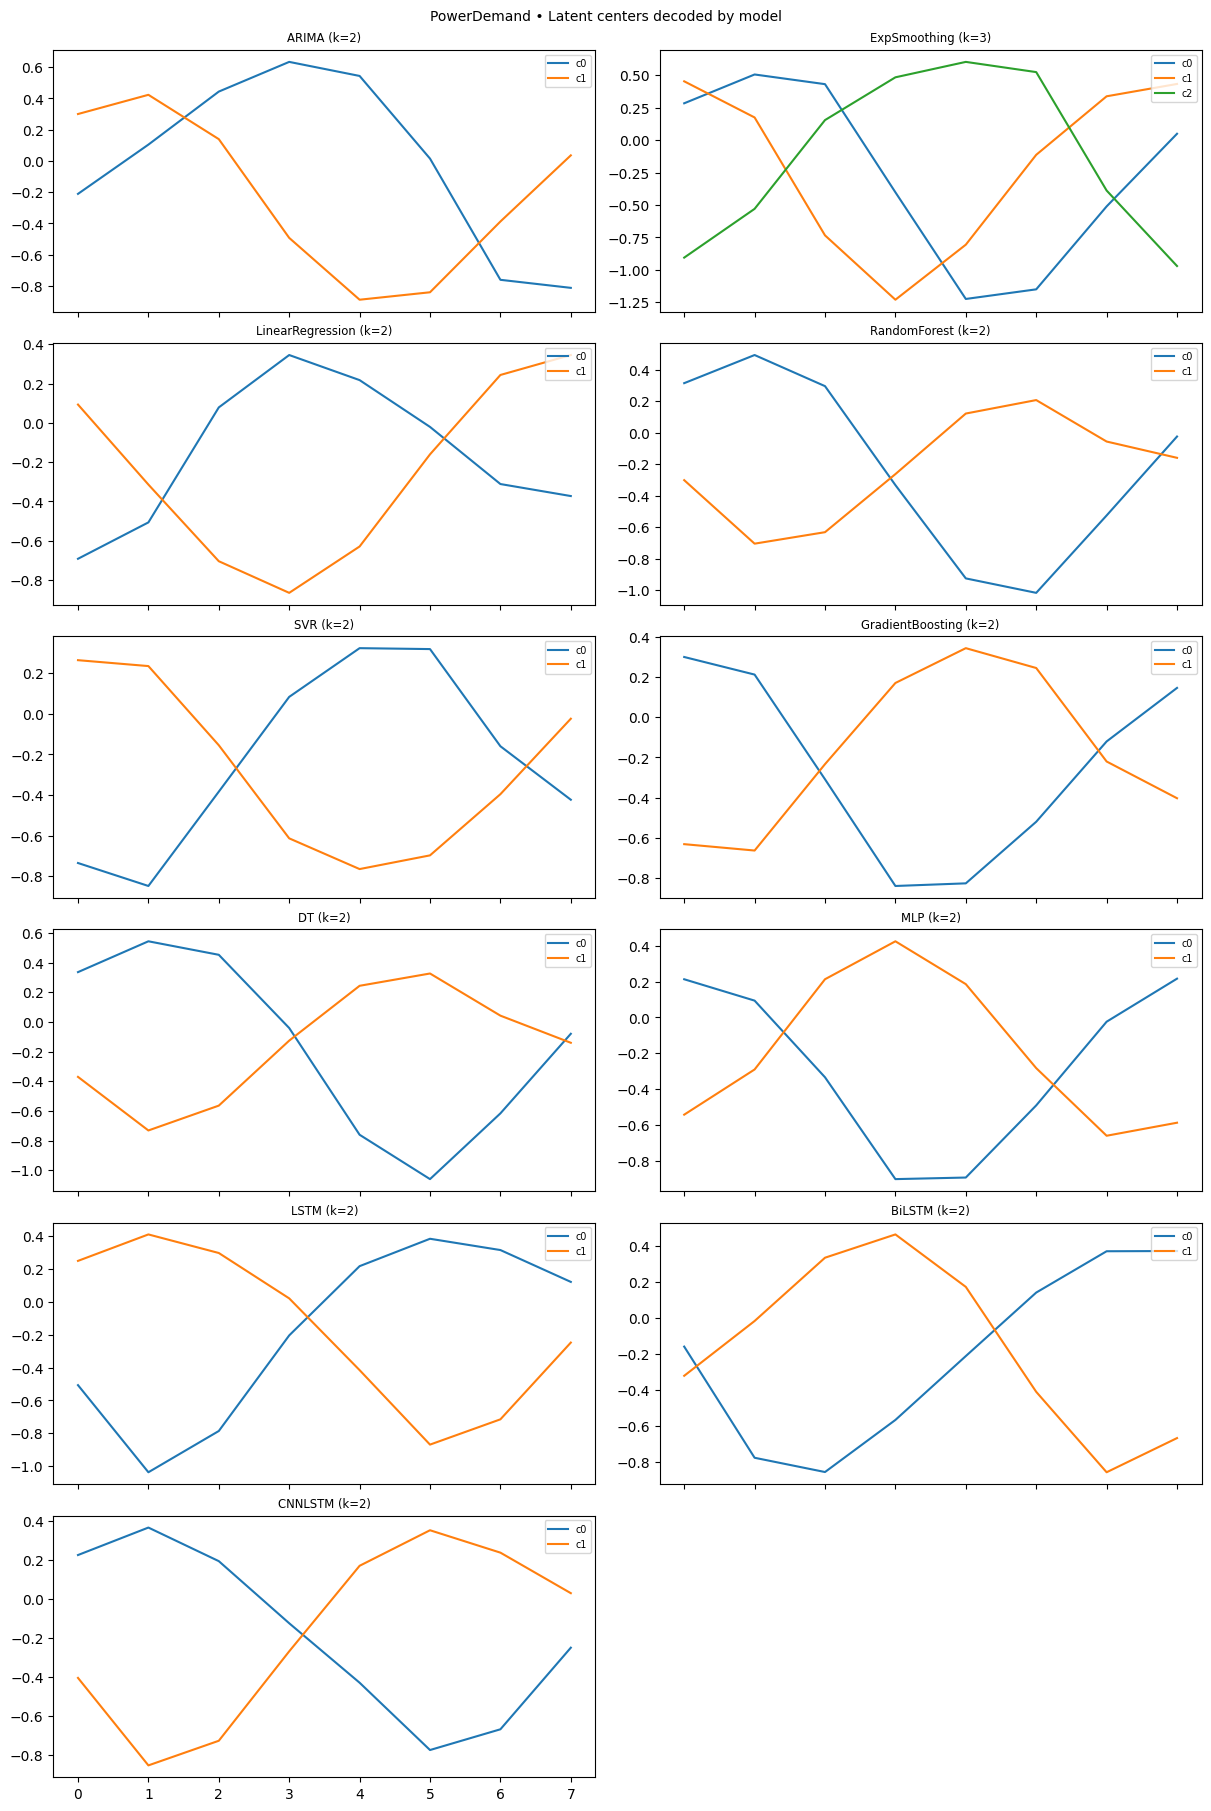

In [ ]:
print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Compute K-means centers for {ds_name} (window_size={window_size}) ===")

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear previous latent centers
    for model in forecasters.values():
        model.centers.clear()

    # Determine device for decoding
    decoder_device = next(ae.decoder.parameters()).device

    for name, model in forecasters.items():
        # compute latent-only k-means centers
        N      = len(model.rocs["latent"])
        k_max  = np.sqrt(N/2)
        best_k = model.compute_kmeans_centers(k_max=k_max)

    # Plot
    names = [n for n in forecasters if len(forecasters[n].centers) > 0]
    n_models = len(names)
    if n_models == 0:
        print("  No models have centers to plot.")
        continue

    n_cols = 2
    n_rows = math.ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(12, 3 * n_rows),
                             sharex=True, constrained_layout=True)
    axes = axes.flatten()

    for ax, name in zip(axes, names):
        model = forecasters[name]
        for idx, c in enumerate(model.centers):
            # ensure tensor on correct device
            c_tensor = c if isinstance(c, torch.Tensor) else torch.tensor(
                c, dtype=torch.float32
            )
            c_batch = c_tensor.unsqueeze(0).to(decoder_device)  # shape (1, C, L)
            decoded = ae.decoder(c_batch)                       # -> (1, 1, window_size)
            ts_data = decoded.detach().cpu().numpy().flatten()
            ax.plot(ts_data, label=f"c{idx}")
        ax.set_title(f"{name} (k={len(model.centers)})", fontsize="small")
        ax.legend(loc="upper right", fontsize="x-small")

    # turn off any unused subplots
    for ax in axes[n_models:]:
        ax.axis("off")

    plt.suptitle(f"{ds_name} • Latent centers decoded by model", fontsize="medium")
    plt.show()

## RQ1: Latent vs. Raw Space for Model Selection Across Distance Metrics

The goal is to compare the effectiveness of model selection based on similarity in latent space (via autoencoder embeddings) versus raw time-domain. This comparison is conducted across multiple distance measures, including Euclidean, Cosine, and Manhattan, applied in both raw and latent spaces.

### Test 1.1: Forecasting MSE Comparison

We compare one-step-ahead forecasting error (MSE) when selecting forecaster in raw vs. latent space using three distance metrics: Euclidean, Manhattan, and Cosine. For each, lower MSE from latent-space selection indicates that the latent embedding preserves meaningful similarity under the corresponding metric. 

In [ ]:
# Lists to collect detailed disagreements and high-level summaries
disagreements = []
summary_list = []

# Ensure a clean results/ directory
RESULTS_DIR = "results"
if os.path.exists(RESULTS_DIR):
    shutil.rmtree(RESULTS_DIR)
os.makedirs("results", exist_ok=True)

print(f"Bottleneck size: {latent_dim}")

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load forecasters
    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    n_windows = len(X_test)

    for metric in metrics_list:
        # ---- RAW inference ----
        t0 = time.perf_counter()
        raw_preds, raw_models = [], []
        for w in X_test:
            q = w  # raw query
            # nearest‐RoC lookup in raw space
            best_name, best_dist = None, float("inf")
            for name, model in forecasters.items():
                for entry in model.rocs["raw"]:
                    d = compute_distance(q, entry, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name
            raw_models.append(best_name)
            raw_preds.append(forecasters[best_name].predict(w))
        time_raw = time.perf_counter() - t0
        mse_raw  = mean_squared_error(y_test, raw_preds)

        # ---- LATENT inference ----
        t1 = time.perf_counter()
        lat_preds, lat_models = [], []
        for w in X_test:
            with torch.no_grad():
                q = ae.encode(w).cpu()  # latent query (torch.Tensor)
            best_name, best_dist = None, float("inf")
            for name, model in forecasters.items():
                for entry in model.rocs["latent"]:
                    # entry is already a tensor
                    d = compute_distance(q, entry, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name
            lat_models.append(best_name)
            lat_preds.append(forecasters[best_name].predict(w))
        time_lat = time.perf_counter() - t1
        mse_lat  = mean_squared_error(y_test, lat_preds)

        # ---- Record disagreements ----
        n_dis = 0
        for idx, (rm, lm, yt, pr, pl) in enumerate(zip(raw_models, lat_models, y_test, raw_preds, lat_preds)):
            if rm != lm:
                n_dis += 1
                disagreements.append({
                    "dataset":      ds_name,
                    "metric":       metric,
                    "win_idx":      idx,
                    "raw_model":    rm,
                    "lat_model":    lm,
                    "y_true":       yt,
                    "y_pred_raw":   pr,
                    "y_pred_lat":   pl,
                })
        rate = n_dis / n_windows

        # ---- Append summary ----
        summary_list.append({
            "dataset":          ds_name,
            "metric":           metric,
            "test_mse_raw":     mse_raw,
            "test_mse_lat":     mse_lat,
            "time_raw":         time_raw,
            "time_lat":         time_lat,
            "n_disagreements":  n_dis,
            "disagreement_rate":rate,
        })

        # ---- Print results ----
        print(
            f"[{metric:^9}] "
            f"raw MSE={mse_raw:.4f}@{time_raw:.2f}s | "
            f"lat MSE={mse_lat:.4f}@{time_lat:.2f}s | "
            f"dis={n_dis}/{n_windows} ({rate:.2%})  | "
            f"%‐improvement: {1 - mse_lat/mse_raw:.2%}"
        )

df_dis  = pd.DataFrame(disagreements)
df_sum  = pd.DataFrame(summary_list)

# save for later
df_dis.to_csv("results/disagreements.csv", index=False)
df_sum.to_csv("results/validation.csv",    index=False)

Bottleneck size: 8

=== Dataset: PowerDemand ===
[euclidean] raw MSE=0.0484@17.52s | lat MSE=0.0523@49.44s | dis=1286/2915 (44.12%)  | %‐improvement: -8.09%
[manhattan] raw MSE=0.0493@23.17s | lat MSE=0.0521@52.44s | dis=1364/2915 (46.79%)  | %‐improvement: -5.74%
[ cosine  ] raw MSE=0.0455@34.44s | lat MSE=0.0516@119.64s | dis=1845/2915 (63.29%)  | %‐improvement: -13.49%


### Test 1.2: Win Rate Analysis

For each metric, we compute the win-rate as the fraction of windows where the latent-space model outperforms the raw model . A win-rate above 50% indicates more frequent wins for the latent model. This analysis complements MSE results to explore whether performance gains arise from consistent small wins or a few large ones.

In [ ]:
df_dis['raw_error'] = (df_dis['y_pred_raw'] - df_dis['y_true'])**2
df_dis['lat_error'] = (df_dis['y_pred_lat'] - df_dis['y_true'])**2
df_dis['winner'] = np.where(df_dis['lat_error'] < df_dis['raw_error'],
                            'latent', 'raw')

# Count wins among disagreements
win_counts = (
    df_dis
    .groupby(['dataset','metric','winner'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={'raw':'raw_wins','latent':'latent_wins'})
)

# Compute win‐rates (conditional on disagreement)
win_rates = win_counts.div(win_counts.sum(axis=1), axis=0) \
                      .rename(columns={'raw_wins':'raw_win_rate',
                                       'latent_wins':'latent_win_rate'})

# Merge rates into the summary table
df_full = (
    df_sum
    .merge(win_rates.reset_index(), on=['dataset','metric'], how='left')
    .fillna(0)
    .assign(
        same_decision_rate = 1 - df_sum['disagreement_rate']
    )
)

# Display results
display(
    df_full[[
        'dataset','metric',
        'raw_win_rate','latent_win_rate','same_decision_rate'
    ]]
)

# Save for later
win_rates.to_csv("results/win_rates.csv", index=False)

,dataset,metric,raw_win_rate,latent_win_rate,same_decision_rate
0,PowerDemand,euclidean,0.546656,0.453344,0.558834
1,PowerDemand,manhattan,0.538856,0.461144,0.532075
2,PowerDemand,cosine,0.542005,0.457995,0.367067


### Test 1.3: Weighted Win-Rate and SSE Reduction

We compute per-window MSE differences to evaluate whether raw or latent selection yields lower errors. Win rates are weighted by the maximum error per window. Additionally, we report the percentage reduction in total sum of squared errors (SSE) when using latent over raw selection.

In [ ]:
print(f"Bottleneck size: {latent_dim}")
# --- compute per-window MSEs and delta using actual column names ---
df_dis['mse_raw']    = (df_dis['y_pred_raw'] - df_dis['y_true'])**2
df_dis['mse_latent'] = (df_dis['y_pred_lat'] - df_dis['y_true'])**2
df_dis['delta_mse']  = df_dis['mse_raw'] - df_dis['mse_latent']


# --- weighted win-rate (weight = max error per window) ---
df_dis['weight'] = df_dis[['mse_raw', 'mse_latent']].max(axis=1)
w_raw    = df_dis.loc[df_dis['delta_mse'] < 0, 'weight'].sum()
w_latent = df_dis.loc[df_dis['delta_mse'] > 0, 'weight'].sum()
wr_raw   = w_raw    / (w_raw + w_latent)
wr_latent= w_latent / (w_raw + w_latent)
print(f"    Weighted raw win-rate:    {wr_raw:.3f}")
print(f"    Weighted latent win-rate: {wr_latent:.3f}")

# --- percent reduction in total SSE ---
sse_raw    = df_dis['mse_raw'].sum()
sse_latent = df_dis['mse_latent'].sum()
pct_reduction = (sse_raw - sse_latent) / sse_raw * 100
print(f"    Latent vs. raw SSE reduction: {pct_reduction:.2f}%")

Bottleneck size: 8
    Weighted raw win-rate:    0.562
    Weighted latent win-rate: 0.438
    Latent vs. raw SSE reduction: -15.93%


## RQ2: Cluster-Based Latent Selection
Model selection is performed using nearest latent cluster centers instead of full RoCs. For each test window, the closest cluster center (per metric) is used to select the forecasting model. Inference time and test MSE are recorded.


### Test 2.1: Forecasting MSE Comparison

Again here we compare one-step-ahead forecasting error (MSE) when selecting forecaster with the full RoC versus the cluster centers computer earlier using three distance metrics: Euclidean, Manhattan, and Cosine.

In [ ]:
# Load previously computed summary for raw vs. latent
df_prev = pd.read_csv("results/validation.csv")

summary_list = []

print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")

    # rebuild splits
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load forecasters and AE
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    n_windows   = len(X_test)

    for metric in metrics_list:
        # ---- LATENT inference (cluster-center lookup) ----
        t0 = time.perf_counter()
        lat_preds = []
        for w in X_test:
            # encode window
            with torch.no_grad():
                q = ae.encode(w).cpu()

            best_name, best_dist = None, float("inf")
            for name, model in forecasters.items():
                for center in model.centers:
                    d = compute_distance(q, center, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name

            lat_preds.append(forecasters[best_name].predict(w))

        time_cluster = time.perf_counter() - t0
        mse_cluster  = mean_squared_error(y_test, lat_preds)

         # fetch standard latent‐based results
        prev_row      = df_prev[(df_prev['dataset']==ds_name)&(df_prev['metric']==metric)].iloc[0]
        mse_standard  = prev_row['test_mse_lat']
        time_standard = prev_row['time_lat']

        # compute delta and print with arrow‐style indicator
        delta = mse_cluster - mse_standard
        sign  = "+" if delta > 0 else "–"
        print(
            f"[{metric:^9}] "
            f"cluster MSE={mse_cluster:.4f}@{time_cluster:.2f}s "
            f"{sign}{abs(delta):.4f} vs. full RoC ({mse_standard:.4f}@{time_standard:.2f}s)"
        )

        summary_list.append({
            "dataset":       ds_name,
            "metric":        metric,
            "cluster_mse":   mse_cluster,
            "time_cluster":  time_cluster,
        })

# tabulate and save
df_sum = pd.DataFrame(summary_list)
df_sum.to_csv("results/cluster.csv", index=False)

Bottleneck size: 8

=== Dataset: PowerDemand ===
[euclidean] cluster MSE=0.0865@5.44s +0.0342 vs. full RoC (0.0523@49.44s)
[manhattan] cluster MSE=0.0908@5.18s +0.0387 vs. full RoC (0.0521@52.44s)
[ cosine  ] cluster MSE=0.0826@5.36s +0.0310 vs. full RoC (0.0516@119.64s)
